## Set up

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import seaborn as sns
import os
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
import warnings
import lightning.pytorch as pl
import torch
import pickle

from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE, QuantileLoss, RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)
from lightning.pytorch.tuner import Tuner
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

np.random.seed(42)

In [3]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'

def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''

def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

## Import the data

In [4]:
online_retail_df = pd.read_json('../../dataset/online_retail_data/online_retail.json')
online_retail_df

,Description,Date,UnitsSold,PricePerUnitPounds,RevenuePounds
0,12 pencils small tube red spotty,2009-12-01,45,0.76,34.20
1,12 pencils small tube red spotty,2009-12-02,87,0.74,64.38
2,12 pencils small tube red spotty,2009-12-03,34,0.76,25.84
3,12 pencils small tube red spotty,2009-12-04,84,0.73,61.32
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.00
...,...,...,...,...,...
73299,heart of wicker large,2010-12-05,94,2.92,274.48
73300,heart of wicker large,2010-12-06,34,3.94,133.96
73301,heart of wicker large,2010-12-07,462,3.48,1607.76
73302,heart of wicker large,2010-12-08,35,3.32,116.20


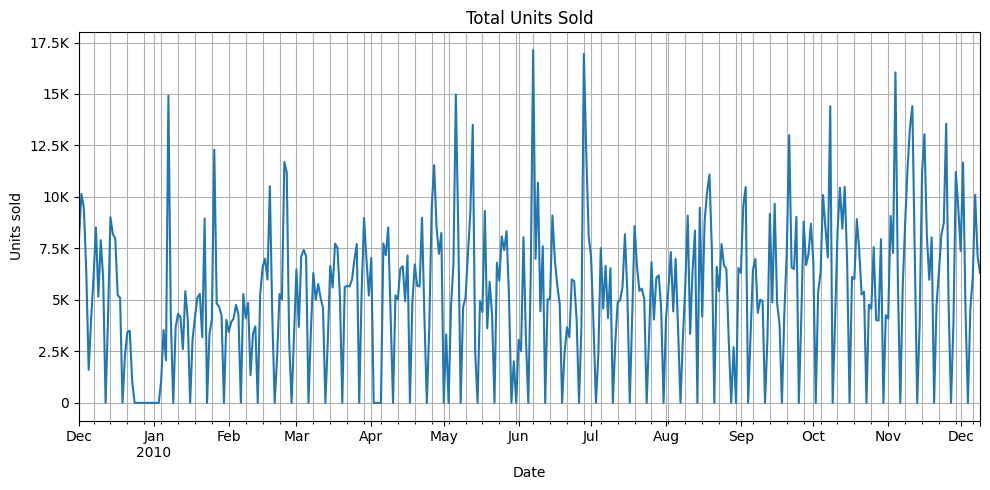

In [4]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['UnitsSold'].sum().plot(ax=ax)

ax.set_title('Total Units Sold')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

## Prepare the dataset

In [5]:
# The PyTorch TFT expects the time axis to be a 
# natural number, not datetime, so we format the
# data appropriately.
formatted_df = online_retail_df.rename(columns={
    'Description': 'ProductId'
})
formatted_df = formatted_df.sort_values(['Date', 'ProductId'])
formatted_df.loc[:,'TimeIdx'] = formatted_df.groupby("ProductId").cumcount()
formatted_df = formatted_df[['TimeIdx', 'ProductId', 'UnitsSold']].reset_index()
formatted_df['UnitsSold'] = formatted_df['UnitsSold'].astype(float)
formatted_df

,index,TimeIdx,ProductId,UnitsSold
0,0,0,12 pencils small tube red spotty,45.0
1,374,0,12 pencils tall tube posy,69.0
2,748,0,12 pencils tall tube woodland,4.0
3,1122,0,3 stripey mice feltcraft,9.0
4,1496,0,6 ribbons rustic charm,27.0
...,...,...,...,...
73299,52359,373,wooden picture frame white finish,22.0
73300,72181,373,wooden school colouring set,13.0
73301,52733,373,woodland charlotte bag,5.0
73302,53107,373,world war 2 gliders asstd designs,52.0


In [6]:
training_cutoff = formatted_df['TimeIdx'].max() - 30  # Leave 30 days for validation
min_prediction_length = 1  # day
max_prediction_length = 30  # days
min_encoder_length = 30  # days
max_encoder_length = 30  # days

training_dataset = TimeSeriesDataSet(
    formatted_df[lambda x: x['TimeIdx'] <= training_cutoff],
    time_idx='TimeIdx',
    target='UnitsSold',
    group_ids=['ProductId'],
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['ProductId'],
    static_reals=[],
    time_varying_known_categoricals=[],
     # group of categorical variables can be treated as one variable
    variable_groups={},
    time_varying_known_reals=['TimeIdx'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['UnitsSold'],
    target_normalizer=GroupNormalizer(
        groups=['ProductId'], transformation='softplus'),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Create a validation set (predict=True) which means to predict the last
# max_prediction_length points in time for each series.
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset,
    formatted_df,
    predict=True,
    stop_randomization=True,
)

# Create dataloaders for the model
batch_size = 32
train_dataloader = training_dataset.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation_dataset.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

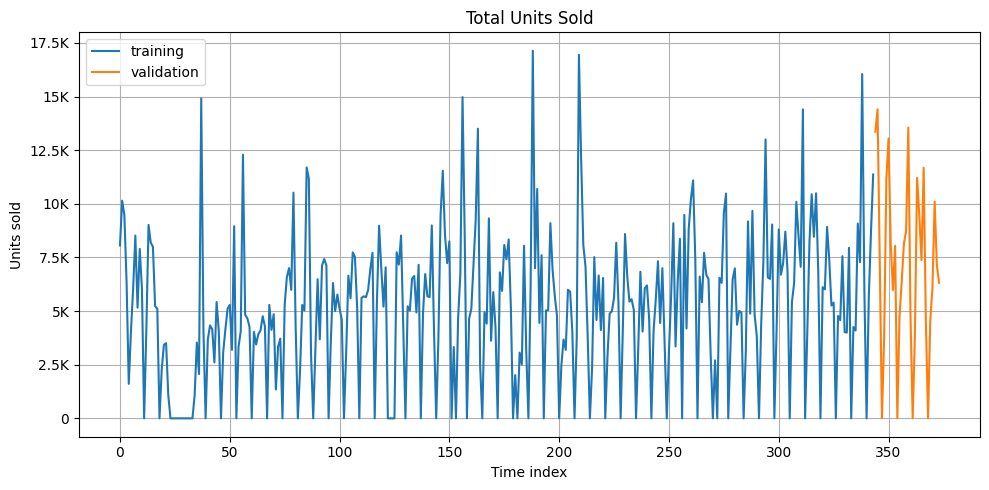

In [7]:
training_total = (
    formatted_df[lambda x: x['TimeIdx'] <= training_cutoff]
    .groupby('TimeIdx')['UnitsSold']
    .sum()
    .sort_index())
validation_total = (
    formatted_df[lambda x: x['TimeIdx'] > training_cutoff]
    .groupby('TimeIdx')['UnitsSold']
    .sum()
    .sort_index())

fig, ax = plt.subplots(figsize=(10,5))

training_total.plot(ax=ax, label='training')
validation_total.plot(ax=ax, label='validation')

ax.set_title('Total Units Sold')
ax.set_xlabel('Time index')
ax.set_ylabel('Units sold')
ax.legend()
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

## Train model

In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.2,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.01,
    hidden_size=95,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=57,
    loss=RMSE(),
    # log_interval=10,
    optimizer="ranger",
    reduce_on_plateau_patience=4,
)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | RMSE                            | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 6.1 K  | train
3  | prescalers                         | ModuleDict                      | 684    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 55.8 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 55.5 K | train
6  | decoder_var

Epoch 0:  22%|▏| 453/2100 [00:48<02:55,  9.37it/s, v_num=11, train_loss_step=63.